# Fetal health classification

For this task, a dataset Fetal Healt Classification was used. You can find it here: https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download. Kaggle is a great platform for finding not only datasets, but also models. In addition, you can compete there in competitions or discuss about datasets and ML.


The task is to determine the health of a fetal. For this, you will use data from Cardiotocograms (CTGs). Cardiotocogram sends ultrasound pulses and reads its response, thus it allows to get fetal heart rate (FHR), fetal movements, uterine contractions and more.

## Data loading

### Option A: Loading directly from Kagglehub

In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd

path = kagglehub.dataset_download("andrewmvd/fetal-health-classification")

print("Path to dataset files:", path)

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv(f'{path}/fetal_health.csv')

### Option B: Loading from a csv file

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('fetal_health.csv')


## Data analysis

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [3]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode         

As you can see, there are 2126 rows. There is no null value, which is great. In the case of null values, you would need to use some technique to come up with these missing values (e.g. average from that column). 
From the type we can see that we have decimal numbers in all columns.

In [4]:
print("\nDescriptive statistics:")
print(df.describe())


Descriptive statistics:
       baseline value  accelerations  fetal_movement  uterine_contractions  \
count     2126.000000    2126.000000     2126.000000           2126.000000   
mean       133.303857       0.003178        0.009481              0.004366   
std          9.840844       0.003866        0.046666              0.002946   
min        106.000000       0.000000        0.000000              0.000000   
25%        126.000000       0.000000        0.000000              0.002000   
50%        133.000000       0.002000        0.000000              0.004000   
75%        140.000000       0.006000        0.003000              0.007000   
max        160.000000       0.019000        0.481000              0.015000   

       light_decelerations  severe_decelerations  prolongued_decelerations  \
count          2126.000000           2126.000000               2126.000000   
mean              0.001889              0.000003                  0.000159   
std               0.002960            

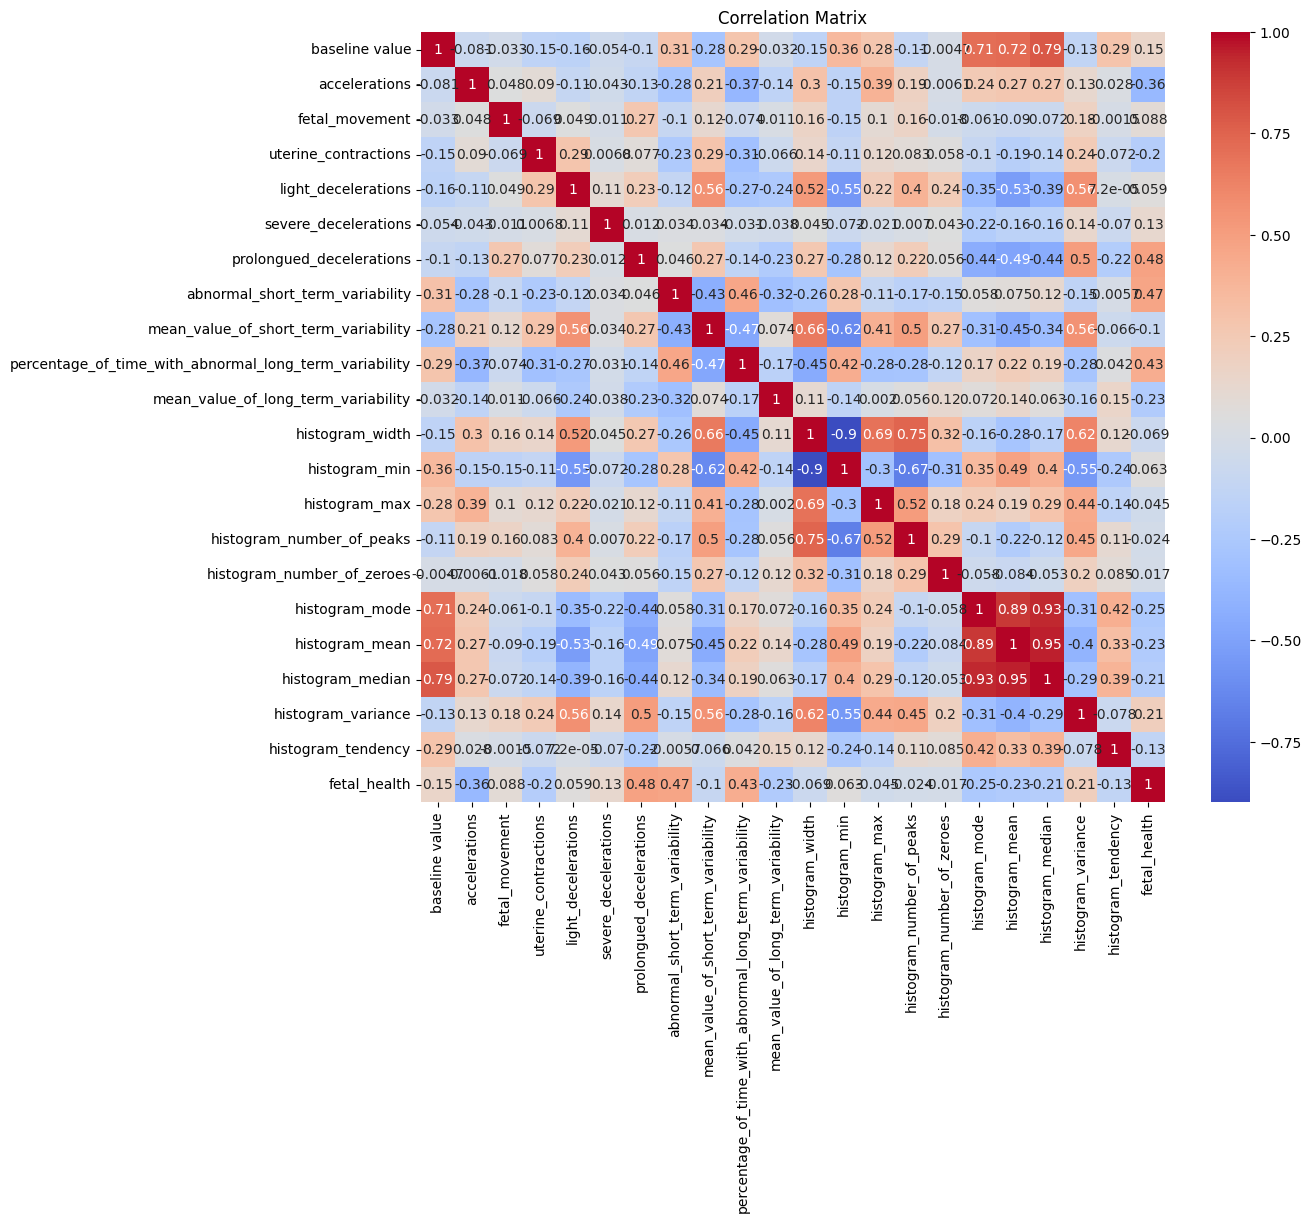

In [5]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Correlation matrix can show us which features are correlated. Usually, correlated features contain redundant data, we can omit them while training a model. In our example, there is a strong correlation for example between histogram_median and histogram_mean, therefore we don't need to use them both while training.

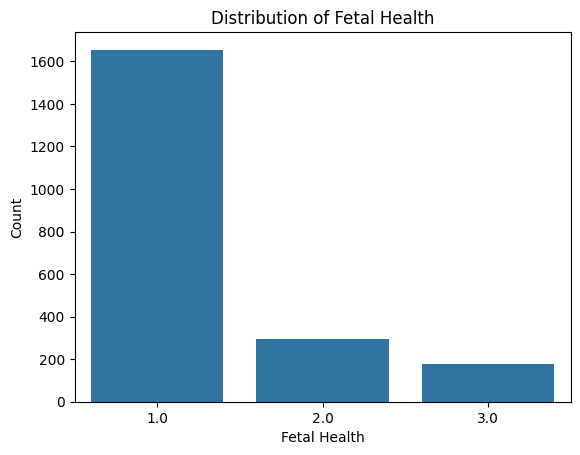

In [6]:
# Visualize the distribution of the target variable
sns.countplot(x='fetal_health', data=df)
plt.title('Distribution of Fetal Health')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.show()

It is worth to note that 1.0, 2.0 and 3.0 doesn't say much. If you wanna work with some dataset, at first, you need to understand it. Dataset's description says:
- 1: Normal
- 2: Suspect
- 3: Pathological

So it is clearly visible that we have most "normal" cases, therefore the dataset is unbalanced. This may play a role while training the model! Data analysis really is important.

In [7]:
# Further analysis: Correlation with the target variable
target_correlation = correlation_matrix['fetal_health'].sort_values(ascending=False)
print("\nCorrelation of features with the target variable 'fetal_health':")
print(target_correlation)


Correlation of features with the target variable 'fetal_health':
fetal_health                                              1.000000
prolongued_decelerations                                  0.484859
abnormal_short_term_variability                           0.471191
percentage_of_time_with_abnormal_long_term_variability    0.426146
histogram_variance                                        0.206630
baseline value                                            0.148151
severe_decelerations                                      0.131934
fetal_movement                                            0.088010
histogram_min                                             0.063175
light_decelerations                                       0.058870
histogram_number_of_zeroes                               -0.016682
histogram_number_of_peaks                                -0.023666
histogram_max                                            -0.045265
histogram_width                                          -0.068

From this correlation with target variable we can conclude that for example 'histogram_number_of_zeroes' variable has very small impact on target. It may not be necessary to include it for model training.

## Model training: Version Tensorflow

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2024-10-21 21:55:50.456972: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 21:55:50.457573: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 21:55:50.459636: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 21:55:50.464854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 21:55:50.476356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [9]:
X = df.drop(columns=["fetal_health", "histogram_median"])
y = df['fetal_health'] - 1  # Shift labels to start from 0
print(X.shape)
print(y.shape)

(2126, 20)
(2126,)


Y is the result we are trying to predict.

X are all the features we are using for prediction. Please, note that we deleted the correlated column histogram_median. You can also delete other correlated columns, this is just an example. Currently we are using 20 columns, as you can see in the shape.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Scaling is a commonly used preprocessing technique if you work with numbers. StandardScaler from scikit library transforms the features to have mean of 0 and a standard deviation of 1. This helps the model to converge faster, usually. For some ML algorithms it is more important than for others, it is a general practice and you can, of course, experiment with other preprocessing techniques. Training a successfull model is not just about the model itself, you need to work with data carefully, as well.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=113)

We splitted data into train set and test set. We used X_scaled and set test_size 0.2. You can experiment with different percentage. Very often, the split train/test ratio is 80/20.

In [12]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

/home/ad1775/hackathon/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We created a very simple sequential model with 4 layers. The first one has input dimension based on the input size. Two following layers are dense layers, you can experiment with their size. The last one has 3 neurons, because we are doing a classification to 3 classes (normal, suspect, pathological).

Unfortunately, there is no rule "how to build a good neural network". You have to run some experiments, try different number of layers, different sizes etc. 

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

There is a lot of opportunities for experiments with different optimizers, losses, and metrics. Please, mind, that sometimes some options will not work for your problem. For example:

If your Yi's are one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1]
But if your Yi's are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: [1] , [2], [3]

In general, you can find information about what to use when in the documentation (tensorflow official documentation), Google, StackOverflow, or just ask chatGPT!

In [14]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.3f}')

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7937 - loss: 0.7207 - val_accuracy: 0.8451 - val_loss: 0.3780
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8740 - loss: 0.3286 - val_accuracy: 0.8803 - val_loss: 0.2974
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8951 - loss: 0.2835 - val_accuracy: 0.8732 - val_loss: 0.2582
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9139 - loss: 0.2245 - val_accuracy: 0.8685 - val_loss: 0.2622
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9137 - loss: 0.2133 - val_accuracy: 0.8944 - val_loss: 0.2378
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9210 - loss: 0.1833 - val_accuracy: 0.8873 - val_loss: 0.2342
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9354 - loss: 0.1671 - val_accuracy: 0.8709 - val_loss: 0.2313
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9294 - loss: 0.1721 - val_accuracy: 0.8920 - val_loss:

In [15]:
predictions = model.predict(X_test[:20])

predicted_classes = tf.argmax(predictions, axis=1)
print("Predicted classes:", predicted_classes.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted classes: [0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 1 0]


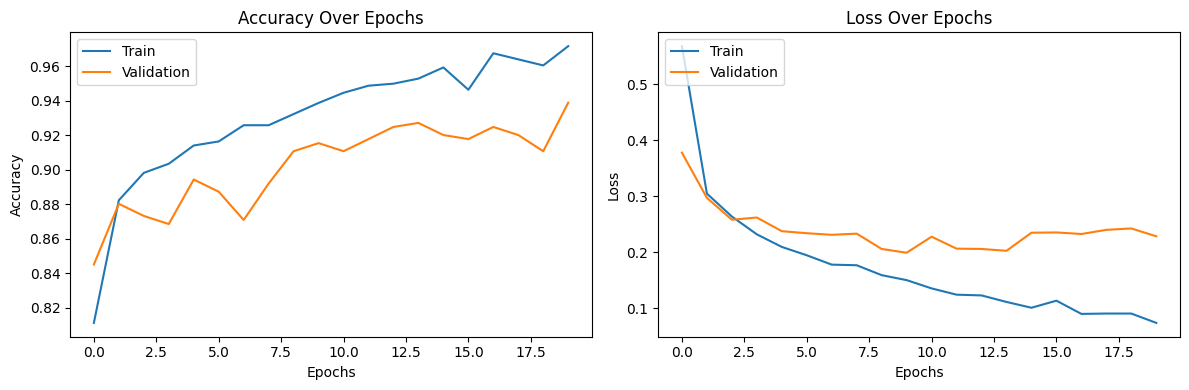

In [16]:
import matplotlib.pyplot as plt

def visualize_training_results(training_history):
    # Create a figure for accuracy and loss
    plt.figure(figsize=(12, 4))

    # Subplot for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['accuracy'], label='Train')
    plt.plot(training_history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')

    # Subplot for loss
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'], label='Train')
    plt.plot(training_history.history['val_loss'], label='Validation')
    plt.title('Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function with your training history
visualize_training_results(history)